# Tennis: Collaboration and Competition

---

### 1.- Setting the environment

In [1]:
#!pip -q install ./python

%config IPCompleter.greedy=True
from unityagents import UnityEnvironment
import numpy as np
import random
from datetime import datetime

aws_unity_filename= './Tennis_Linux_NoVis/Tennis.x86_64'
udacity_unity_filename= "/data/Tennis_Linux_NoVis/Tennis"
laptop_unity_filename= './Tennis_Linux/Tennis.x86_64'
seed= 0 
env = UnityEnvironment(seed= seed, file_name= laptop_unity_filename)
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

#Handy functions to help understand the code
def env_reset(train=True):
    env_info = env.reset(train_mode= train)[env.brain_names[0]]
    return env_info.vector_observations

def env_step(action):
    env_info= env.step(action)[env.brain_names[0]]
    return env_info.vector_observations, env_info.rewards, env_info.local_done

def env_size():
    env_info = env.reset(train_mode= False)[env.brain_names[0]]
    state_size= env_info.vector_observations.shape[1]
    action_size= brain.vector_action_space_size
    num_agents= len(env_info.agents)
    return state_size, action_size, num_agents

def new_seed():
    seed= datetime.now().second
    random.seed(seed)
    torch.manual_seed(seed)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


### 2.- Training

Episode 100	Average Score: 0.02   
Episode 200	Average Score: 0.06   
Episode 300	Average Score: 0.06   
Episode 400	Average Score: 0.02   
Episode 500	Average Score: 0.03   
Episode 600	Average Score: 0.09   
Episode 700	Average Score: 0.09   
Episode 800	Average Score: 0.12   
Episode 894	Average Score: 0.52   
Environment solved in 794 episodes!	Average Score: 0.52


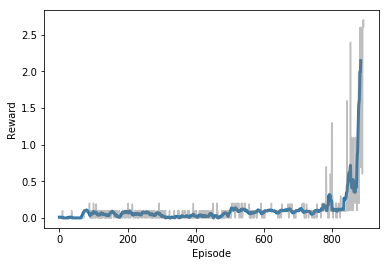

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import torch

from collections import deque
from datetime import datetime

from ddpg import DDPG
from agents import Agents

NUM_EPISODES = 2000
SOLVED_CONDITION= 0.5

# Hyperparameters
config= {
    "seed": seed,
    "actor_lr": 1e-3,
    "critic_lr": 1e-3,
    "actor_nodes": [32, 32],
    "critic_nodes": [256, 256],
    "batch_size": 256,
    "memory_size": 100000,
    "discount": 0.9,
    "tau": 1e-3,
    "critic_l2_reg": 0.0,  # 1e-2
    "action_noise": "Param",    # Options: No, Normal, OU, Param
    "sigma": 0.1,            # OUNoise, Normal
    "experience": "all",     # Options: self, all
    "multi-agent": False,
}

state_size, action_size, num_agents= env_size()
agents= Agents(state_size, action_size, num_agents, config= config)

scores_window = deque(maxlen=100)
solved_in= 0


for episode in range(NUM_EPISODES):
    states= env_reset(True)
    agents.reset()
    score = np.zeros(num_agents)
    
    while True:
        actions= agents.act(states)    # Agent action. Include noise
        next_states, rewards, dones= env_step(actions)   # Environmet step
        agents.step(states, actions, rewards, next_states, dones)
        
        score+= rewards        # update the score
        states= next_states     # roll over the state to next time step
        if np.any(dones):              # exit loop if episode finished
            break
    
    
    max= np.max(score)
    agents.update(max)          # Add score to agents and update param noise
    scores_window.append(max)       
    mean_w_scores= np.mean(scores_window)
    print('\rEpisode {}\tAverage Score: {:.2f}   '.format(episode+ 1, mean_w_scores), end="")
    if (episode+ 1) % 100 == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}   '.format(episode+ 1, mean_w_scores))
    if mean_w_scores >= SOLVED_CONDITION:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format((episode+ 1)-100, mean_w_scores))
        solved_in= (episode+ 1)-100
        break
        
agents.save(solved_in)
        
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

smoothed_scores= running_mean(agents.scores, 10)
plt.plot(np.arange(len(smoothed_scores)), smoothed_scores, linewidth= 3)
plt.plot(np.arange(len(agents.scores)), agents.scores, color='grey', alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Reward')


plt.show()


### 3.- See how the agent behaves

In [3]:

state_size, action_size, num_agents= env_size()

agents= Agents(state_size, action_size, num_agents, config= config)

agents.load()
agents.eval()

states= env_reset(train=False)

score = np.zeros(num_agents)                       # initialize the score
while True:
    actions= agents.act(states, False)
    next_states, rewards, dones= env_step(actions)
    score += rewards                                # update the score
    states= next_states   
    if np.any(dones):                                       # exit loop if episode finished
        break
    
print("Score: {:.1f}".format(np.max(score)))


Score: 2.6
